# Useful references

## Python + Numpy + Matplotlib + etc.

* Python Numpy Tutorial: http://cs231n.github.io/python-numpy-tutorial/
* Computational Statistics in Python: https://people.duke.edu/~ccc14/sta-663/
* Numpy for MATLAB users: https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html
* MATLAB synonymous commands in Python/NumPy: http://mathesaurus.sourceforge.net/

## NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/static/docs/neuronpython/index.html

## NMODL
* NEURON Extension to NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl2.html
* NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html#nmodl




In [1]:
%%bash

# Don't forget compiling mod files.

cd mod.files
nrnivmodl

/root/Documents/class_4/mod.files
ConnorStevens.mod MorrisLecar.mod adexp.mod ccstdpsyn.mod netstim2.mod wb.mod
ConnorStevens.mod MorrisLecar.mod adexp.mod ccstdpsyn.mod netstim2.mod wb.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o mod_func.lo mod_func.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -O3 -fPIC -fno-strict-aliasing -msse3 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link mpicc -module  -O3 -fPIC -fno-strict-aliasing -msse3    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  ConnorStevens.lo MorrisLecar.lo adexp.lo ccstdpsyn.lo netstim2.lo wb.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs -lnrnmpi -lscopmath -lsparse13 -L/opt/conda/lib/lib -lreadline -lncurses -L"/usr/local/nrn/x

# Synaptic plasticity

Here we show some examples of implementing synaptic plasticity in a network model. We will mainly use the model of spike time-dependent plasticity by Clopath et al. (Nat. Neurosci, 2010).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui, load_mechanisms
load_mechanisms('./mod.files')

True

As the Clopath et al model was implemented with an adaptive exponential integrate-and-fire (AdEX) model, here we first make a cell model, as we have seen before. Note that we add two types of synapses, one non-plastic and the other one based on the Clopath model. The former will be used for triggering spiking in this neuron, while the latter will receive much weaker presynaptic inputs.

In [3]:
from cell_template import Cell

class AdEx(Cell):
    def create_sections(self):
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass
    
    def build_subsets(self):
        pass

    def define_geometry(self):
        self.soma.diam = 12.4
        self.soma.L = 721
        self.area_cm2 = (self.soma.diam*self.soma.L*h.PI*1e-8)
        
    def define_biophysics(self):
        self.soma.insert('pas')
        self.soma.g_pas = 30e-9/self.area_cm2
        self.soma.e_pas = -70.6
        self.adexp = h.AdExpIF(0.5, sec=self.soma)

    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(0.5, sec=self.soma))
        self.synlist[-1].tau1 = 0.001
        self.synlist[-1].tau2 = 0.2

        self.synlist.append(h.CCSTDPSyn(0.5, sec=self.soma))
    

Then, we create a cell, two external inputs that connect to the synapses.

In [4]:
cell1 = AdEx()

stim_post = h.NetStim(0.5, sec=cell1.soma)
nc_post = h.NetCon(stim_post, cell1.synlist[0])

stim_pre = h.NetStim(0.5, sec=cell1.soma)
nc_pre = h.NetCon(stim_pre, cell1.synlist[1])

We will simulate the cell according to a protocol to reproduce Fig. 2a in Clopath et al. (2010). 60 pulse stimuli will be delivered at 20 Hz with with a certain time delay between `stim_post` and `stim_pre`.

In [9]:
# We use an adaptive intergrator for higher numerical accuracy that is required to simulate an AdEx model accurately.
cvode = h.CVode()
cvode.active(1)


def run_with_delay(delay):
    h.v_init = -70.6
    h.tstop = 60*50+100

    stim_post.start = 100    # Everything starts at t = 100 ms
    stim_post.number = 60    # 60 pulses
    stim_post.interval = 50  # 20 Hz
    stim_post.noise = 0      # Regular firing

    nc_post.delay = 0.01     
    nc_post.weight[0] = 1.5  # Make a very strong synaptic to make the neuron fire reliably

    stim_pre.start = 100 - delay
    stim_pre.number = 60
    stim_pre.interval = 50
    stim_pre.noise = 0

    nc_pre.delay = 2
    nc_pre.weight[0] = 2e-3    # 2 pS initial weight (synaptic conductance)
    w0 = nc_pre.weight[0]      # Here we record what we start from
    h.init()
    h.run()
    
    return nc_pre.weight[0]/w0 # Return a relative strength of the synapse


Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt


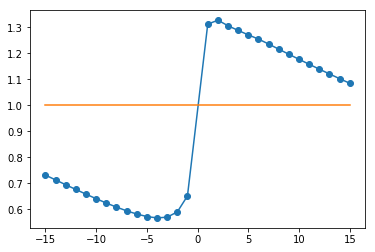

In [10]:
# cell1.synlist[1].tauca = 1
# cell1.synlist[1].Am = 0.8e-6
# cell1.synlist[1].Ap = 1.4e-8
# cell1.synlist[1].taux = 15
# cell1.synlist[1].taum = 10
# cell1.synlist[1].taup = 7


delays = np.arange(-15, 16, 1)
delays = [d for d in delays if np.abs(d)>0]
delg = [run_with_delay(d) for d in delays]

_, ax = plt.subplots()
ax.plot(delays, delg, 'o-', delays, np.ones_like(delays))
# ax.set(ylim=[0.5, 1.5])

Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt


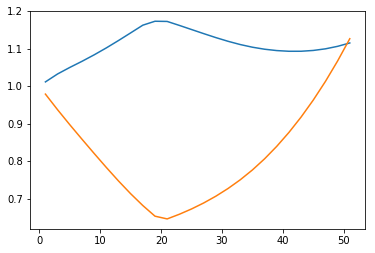

In [7]:
def run_with_delay(delay,freq):
    h.v_init = -70.6
    h.tstop = 60*50+100

    stim_post.start = 100    # Everything starts at t = 100 ms
    stim_post.number = 60    # 60 pulses
    stim_post.interval = 1000/freq #50  # 20 Hz
    stim_post.noise = 0      # Regular firing

    nc_post.delay = 0.01     
    nc_post.weight[0] = 1.5  # Make a very strong synaptic to make the neuron fire reliably

    stim_pre.start = 100 - delay
    stim_pre.number = 60
    stim_pre.interval = 1000/freq
    stim_pre.noise = 0

    nc_pre.delay = 2
    nc_pre.weight[0] = 2e-3 # 2 nS initial weight (synaptic condactance)
    w0 = nc_pre.weight[0]      # Here we record what we start from
    h.init()
    h.run()
    
    return nc_pre.weight[0]/w0 # Return a relative strength of the synapse


freq = np.arange(1, 52, 2)

delg_p = [run_with_delay(10,f) for f in freq]
delg_m = [run_with_delay(-10,f) for f in freq]
    

#delays_inv = [100/abs(d) for d in delays]

_, ax = plt.subplots()
ax.plot(freq, delg_p, '-')
ax.plot(freq, delg_m, '-')
# ax.set(ylim=[0.5, 2])

# Emergence of connectivity from network activity

Here we will construct and run a network simulation that is supposed to reproduce Fig. 4a in Clopath et al. (2010). After resetting the kernel, we redefine `AdEx`.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
from cell_template import Cell

cvode = h.CVode()
cvode.active(1)


class AdEx(Cell):
    def create_sections(self):
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass
    
    def build_subsets(self):
        pass

    def define_geometry(self):
        self.soma.diam = 12.4
        self.soma.L = 721    
        self.area_cm2 = (self.soma.diam*self.soma.L*h.PI*1e-8)
        
    def define_biophysics(self):
        self.soma.insert('pas')
        self.soma.g_pas = 30e-9/self.area_cm2
        self.soma.e_pas = -70.6
        self.adexp = h.AdExpIF(0.5, sec=self.soma)

    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(0.5, sec=self.soma))
        self.synlist[-1].tau1 = 0.001
        self.synlist[-1].tau2 = 0.2

        self.synlist.append(h.CCSTDPSyn(0.5, sec=self.soma))
    

We build our model with `SerialNetManager`: first, we create a network manager for ten neurons, and register an AdEx model for each global id (gid).

In [22]:
from net_manager import SerialNetManager

Ncells = 10

pnm = SerialNetManager(Ncells)
for i in range(Ncells):
    pnm.register_cell(i, AdEx())


We connect each cell by an external input that is stimulated by a random spike generator.

In [23]:
ics_ext = []
ncs_ext = []
for i in range(Ncells):
    ic = h.NetStimFD(pnm.gid2cell[i].soma(0.5)) # pnm.gid2cell[i] gives you a cell object with gid=i
    ic.noise = 1
    ic.start = 0
    ic.duration = 10000
    ic.seed(i+1223)
    
    nc = h.NetCon(ic, pnm.gid2cell[i].synlist[0])
    nc.delay = 0.01
    nc.weight[0] = 1.5
    ics_ext.append(ic)
    ncs_ext.append(nc)


Now, neurons with gid=0...5 will be driven at 2 Hz, while neurons with gid=6...9 will fire at 30 Hz.

In [24]:
for i in range(6):
    ics_ext[i].interval = 1000/2

for i in range(6, 10):
    ics_ext[i].interval = 1000/30


Let's run the model!

Changed dt


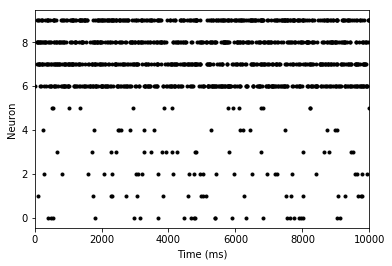

In [25]:
def run():
    pnm.want_all_spikes() # Record spikes from all the cells

    h.tstop = 10000
    h.init()
    pnm.run()

    _, ax = plt.subplots()
    ax.plot(pnm.spikevec, pnm.idvec, '.k')
    ax.set(xlabel='Time (ms)', ylabel='Neuron', xlim=[0, h.tstop])

run()

Since the simulation runs well without connections, we build a baseline connectivity, which will be all-to-all with the same synaptic strength.

In [26]:
pnm.nc_reset()
gsyn0 = 2e-3  # 2 nS

for i in range(Ncells):
    for j in range(Ncells):
        if i!=j:
            pnm.nc_append(i, j, 1, gsyn0, 0.1, thresh=0) 

Here we make a simple function to display the connectivity,

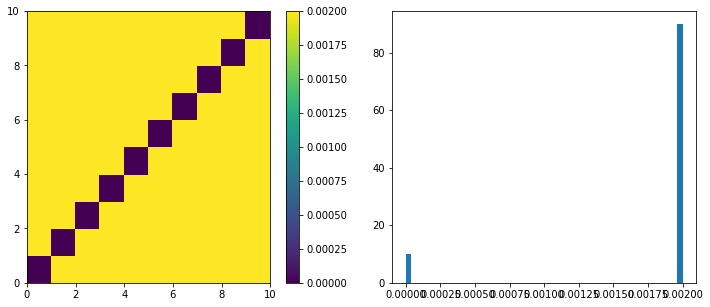

In [27]:
def show_connections():
    conn_mat = np.zeros((Ncells, Ncells))
    for i in range(Ncells):
        for j in range(Ncells):
            if i!=j:
                conn_mat[i, j] = pnm.netcons[(i, j, 1)].weight[0]

    _, ax = plt.subplots(ncols=2, figsize=(12,5))
    c = ax[0].pcolormesh(conn_mat)
    plt.colorbar(c, ax=ax[0])
    _ = ax[1].hist(conn_mat.ravel(), 50)
    
    return conn_mat

conn_mat = show_connections()

Let's run the model again, and check the connections.

Changed dt


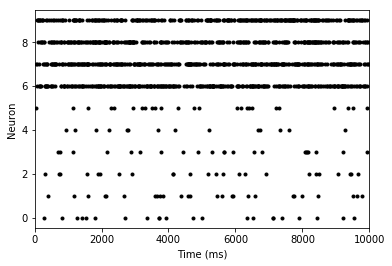

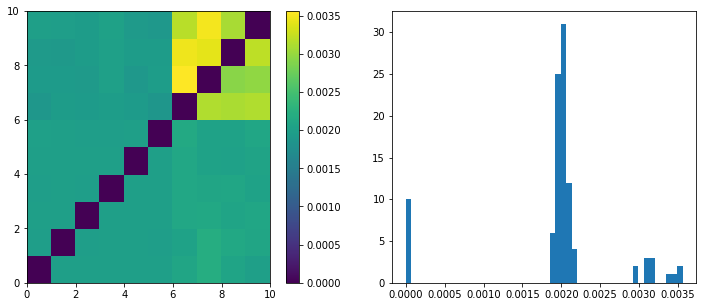

In [28]:
run()
conn_mat = show_connections()